<a href="https://colab.research.google.com/github/vbwanere/SEDS_in_jax/blob/main/k_means_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [ ]:
@jax.jit
def vector_quantize(points, centroids):
    assignment = jax.vmap(
        lambda point: jnp.argmin(jax.vmap(jnp.linalg.norm)(centroids - point))
    )(points)
    distance = jax.vmap(jnp.linalg.norm)(centroids[assignment, :] - points)
    return assignment, distance

In [ ]:
@partial(jax.jit, static_argnums=(2,))
def kmeans_run(key, points, k, thresh=1e-5):

    def improve_centroids(val):
        prev_centroids, prev_distn, _ = val
        assignment, distortions = vector_quantize(points, prev_centroids)

        # Count number of points assigned per centroid
        # (Thanks to Jean-Baptiste Cordonnier for pointing this way out that is
        # much faster and let's be honest more readable!)
        counts = (
            (assignment[jnp.newaxis, :] == jnp.arange(k)[:, jnp.newaxis])
            .sum(axis=1, keepdims=True)
            .clip(a_min=1.)  # clip to change 0/0 later to 0/1
        )

        # Sum over points in a centroid by zeroing others out
        new_centroids = jnp.sum(
            jnp.where(
                # axes: (data points, clusters, data dimension)
                assignment[:, jnp.newaxis, jnp.newaxis] \
                    == jnp.arange(k)[jnp.newaxis, :, jnp.newaxis],
                points[:, jnp.newaxis, :],
                0.,
            ),
            axis=0,
        ) / counts

        # [An alternative version, due to Jean-Baptiste Cordonnier, uses the
        #  undocumented LAX scatter ops. It achieves similar speed here, but
        #  may be worth considering in other workloads?]
        #
        # new_centroids = jnp.zeros_like(prev_centroids)
        # dnums = jax.lax.ScatterDimensionNumbers(update_window_dims=(1,),
        #                                         inserted_window_dims=(0,),
        #                                         scatter_dims_to_operand_dims=(0,))
        # new_centroids = jax.lax.scatter_add(new_centroids,
        #                                     jnp.expand_dims(assignment, -1),
        #                                     points,
        #                                     dnums)
        # new_centroids /= counts

        # For completeness' sake, this was the original I implemented---the cond
        # and individual count divisions makes it very slow though.
        #
        # new_centroids = jnp.stack([
        #     jax.lax.cond(
        #         jnp.any(mask > 0),
        #         None,
        #         (lambda _: jnp.sum(
        #             jnp.where(
        #                 jnp.expand_dims(mask, -1),
        #                 points,
        #                 jnp.zeros_like(points)
        #             ),
        #             axis=0,
        #         ) / jnp.count_nonzero(mask)),
        #         None,
        #         (lambda _: jnp.zeros(points.shape[1:])),
        #     )
        #     for mask in [(assignment == c) for c in range(k)]
        # ])


        return new_centroids, jnp.mean(distortions), prev_distn

    # Run one iteration to initialize distortions and cause it'll never hurt...
    initial_indices = jax.random.shuffle(key, jnp.arange(points.shape[0]))[:k]
    initial_val = improve_centroids((points[initial_indices, :], jnp.inf, None))
    # ...then iterate until convergence!
    centroids, distortion, _ = jax.lax.while_loop(
        lambda val: (val[2] - val[1]) > thresh,
        improve_centroids,
        initial_val,
    )
    return centroids, distortion

In [ ]:
@partial(jax.jit, static_argnums=(2,3))
def kmeans(key, points, k, restarts, **kwargs):
    all_centroids, all_distortions = jax.vmap(
        lambda key: kmeans_run(key, points, k, **kwargs)
    )(jax.random.split(key, restarts))
    i = jnp.argmin(all_distortions)
    return all_centroids[i], all_distortions[i]

In [ ]:
k1, k2, k3, k4 = jax.random.split(jax.random.PRNGKey(0), 4)

points = jnp.concatenate([
    jax.random.normal(k1, (400, 2)) + jnp.array([4, 0]),
    jax.random.normal(k2, (200, 2)) + jnp.array([.5, 1]),
    jax.random.normal(k3, (200, 2)) + jnp.array([-.5, -1]),
])

def find_n_clusters(n_clusters):
    codebook, _ = kmeans(k4, points, n_clusters, 1)
    assignment, _ = vector_quantize(points, codebook)

    for i in range(n_clusters):
        ps = points[assignment == i]
        plt.plot(ps[:,0], ps[:,1], "o", alpha=0.2)

    plt.show()

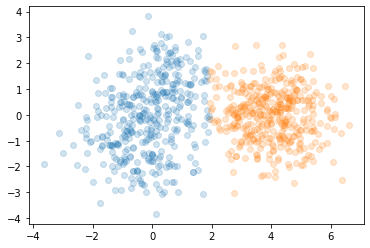

In [ ]:
find_n_clusters(2)

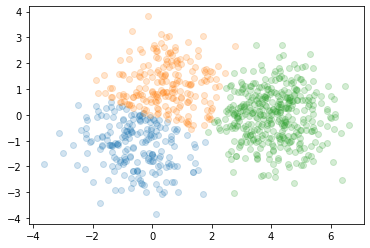

In [ ]:
find_n_clusters(3)

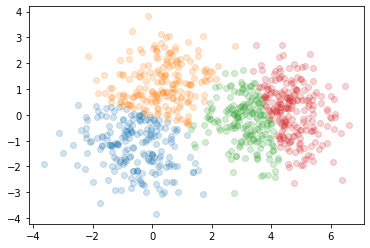

In [ ]:
find_n_clusters(4)

In [ ]:
n_clusters = 50
%time vector_quantize(points, kmeans(jax.random.PRNGKey(0), points, n_clusters, 1)[0])  # JIT
%timeit -r 1 -n 500 vector_quantize(points, kmeans(jax.random.PRNGKey(0), points, n_clusters, 1)[0]) # run

# CPU times: user 1.64 s, sys: 10.4 ms, total: 1.65 s
# Wall time: 1.64 s
# 500 loops, best of 1: 9.68 ms per loop

CPU times: user 6.9 ms, sys: 0 ns, total: 6.9 ms
Wall time: 6.21 ms
500 loops, best of 1: 9.84 ms per loop
